In [1]:
%matplotlib inline
import sys
from u8timeseries import Prophet, KthValueAgoBaseline, ExponentialSmoothing, TimeSeries, Arima, AutoArima
from u8timeseries import StandardRegressiveModel
from u8timeseries.models.regressive_model import RegressiveModel
from u8timeseries.metrics import mape, overall_percentage_error, mase
from u8timeseries.backtesting import simulate_forecast_ar, simulate_forecast_regr, get_train_val_series,\
                                     backtest_autoregressive_model

import pandas as pd
pd.__version__
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

from typing import List, Optional

Ensembling and Backtesting

**Task**: Create a **TimeSeries** from a pandas dataframe loading the retailNz dataset.

In [2]:
# data_key = 'Chemist' # or 'Chemist' or 'Footwear'
# df = pd.read_csv('RetailNZ.csv', sep = ',')
# series = TimeSeries.from_dataframe(df, 'Time', data_key) # we ca explicitely give what column contains values
# series.plot(lw=2)

       date   Close  total-reactions  reactions-like  reactions_love  \
63  2019-06  728.63         599007.0        440453.0        102017.0   
64  2019-07  905.10         651617.5        575417.0         62935.5   
65  2019-08  832.93         504588.0        454450.0         39986.0   
66  2019-09  798.67         459160.5        410703.0         39421.0   
67  2019-10  140.68         218620.0        193025.0         19255.0   

    reactions-haha  reactions-wow  reactions-sad  reactions-angry  comments  \
63         35081.0        14986.0         2268.0           4202.0   32392.0   
64          3713.0         8515.0          609.0            428.0   29847.0   
65          3692.0         5728.0          414.0            318.0   17890.0   
66          2889.5         5369.5          363.0            414.5   18785.5   
67          4396.0         1728.0          124.0             92.0    6771.0   

    ...  engagement_score     value   min_wk  mean_wk   max_wk     std_wk  \
63  ...        

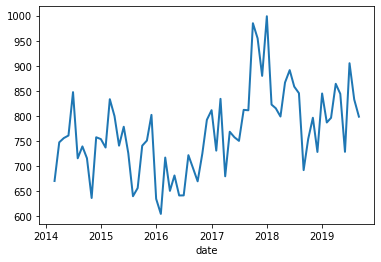

In [51]:
data_key = 'Close' # or 'Chemist' or 'Footwear'
df = pd.read_csv('data/GM_ds.csv', sep = ',')
df2 = df.drop(df.index[-1])
print(df.tail())
print(df2.tail())
# business_days = pd.bdate_range(start=df.iloc[0].values[0], end=df.iloc[-1].values[0])
series = TimeSeries.from_dataframe(df2, 'date', data_key) # we ca explicitely give what column contains values
# print(type(series))
# tmp = series.pd_series().drop(series.pd_series().index[-1])
# print(tmp.head())
# series = TimeSeries.from_dataframe(series.pd_series().drop(series.pd_series().index[-1]), 'date', data_key)
# print(type(series))
series.plot(lw=2)

In [39]:
# print(series.pd_series().head())
# print(series.pd_series().tail())
# print(series.pd_series().drop(series.pd_series().index[-1]))


date
2014-03-01    670.570
2014-04-01    747.520
2014-05-01    755.965
2014-06-01    761.100
2014-07-01    847.510
Freq: MS, dtype: float64
date
2019-06-01    728.63
2019-07-01    905.10
2019-08-01    832.93
2019-09-01    798.67
2019-10-01    140.68
Freq: MS, dtype: float64
date
2014-03-01    670.570
2014-04-01    747.520
2014-05-01    755.965
2014-06-01    761.100
2014-07-01    847.510
               ...   
2019-05-01    844.135
2019-06-01    728.630
2019-07-01    905.100
2019-08-01    832.930
2019-09-01    798.670
Freq: MS, Length: 67, dtype: float64


In [23]:
# # drop_point = int(np.round(series.pd_series().shape[0] * .1))
# # drop_date = series.pd_series().index[drop_point]

# series = series.drop_end(drop_date)

In [24]:
# print(series.pd_series().shape)
# print(drop_point)
# print(drop_date)

In [25]:
# split = int(np.round(series.pd_series().shape[0] * .8))

# print(series.pd_series().index[split])
# print(type(series))
# print(type(pd.Timestamp('20070101')))
# print(pd.Timestamp('20070101') in series.pd_series().index)

In [26]:
# print(series.pd_series().index.values[0])
# print(series.pd_series().index.values[-1])
# print(series.pd_series().shape)
# print(int(np.round(series.pd_series().shape[0] * .8)))

Initialize a series of models

In [52]:
model_es = ExponentialSmoothing()
model_pr = Prophet()
model_ar = AutoArima()

We're going to perform predictions starting 2007.

**Task**: try one of these models and plot the predictions.

54
2018-09-01 00:00:00
(67,)
2014-03-01 00:00:00
2019-09-01 00:00:00


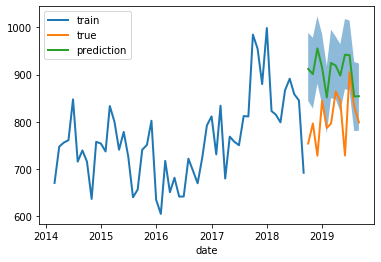

In [53]:
# splitting ratio
split = int(np.round(series.pd_series().shape[0] * .8))
split_date = series.pd_series().index[split]
print(split)
print(split_date)
print(series.pd_series().shape)
print(series.pd_series().index[0])
print(series.pd_series().index[-1])

train, val = series.split_after(split_date)
model_pr.fit(train)
pred = model_pr.predict(len(val))

train.plot(lw=2, label='train')
val.plot(lw=2, label='true')
pred.plot(lw=2, label='prediction')
plt.legend()

## Backtesting

Next, we'll do some backtesting, which means that we will simulate predictions that would have been done historically with a given model.

We are going to simulate forecasts for 6 months in the future, and this number of time steps is called **forecast horizon**.

The model is refit every 6 month with previous step forecast horizon as training data, so this will take some time.

In [54]:
bt_start = time.time()
historical_fcast = simulate_forecast_ar(series, model_es, split_date, fcast_horizon_n=6, verbose=True)
print('Backtesting elapsed time: {}'.format(time.time() - bt_start))


Backtesting elapsed time: 26.646857500076294


Plot the results.

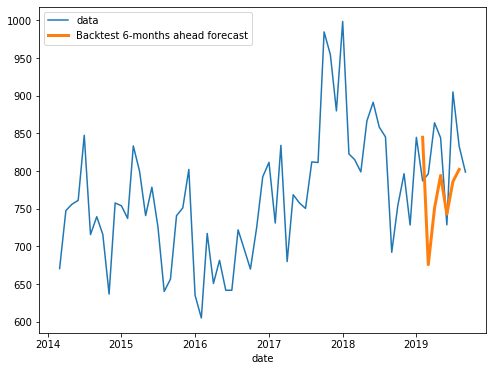

In [55]:
plt.figure(figsize=(8,6))
series.plot(label='data')
historical_fcast.plot(lw=3, label='Backtest 6-months ahead forecast')
plt.legend()

## Backtest the models on the data using a user-defined metric
Here we'll do slightly more advanced backtesting, and use our own metric (in this case the MAPE error function) to compare the different models. We'll simulate 12-months ahead predictions done in the past, starting in January 1955, and the errors will be computed on the 12-months period for which forecasts are done.

In [56]:
def backtest_model(model, series):
    tic = time.time()
    train_val_series = get_train_val_series(series, start=split_date, nr_points_val=12)
    res = backtest_autoregressive_model(model, train_val_series, mape)
    tac = time.time()
    print('Backtest done in %.2f s.' % (tac-tic))
    return res

In [57]:
res_ar = backtest_model(model_ar, series)
res_pr = backtest_model(model_pr, series)

Backtest done in 0.42 s.
Backtest done in 2.33 s.


### Plot the user-defined backtesting results

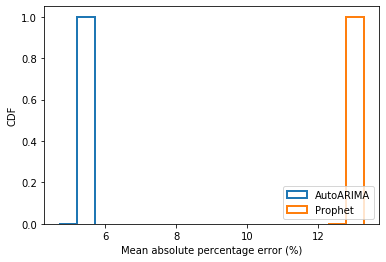

In [58]:
plt.hist(res_ar, bins=50, cumulative=True, histtype='step', 
         lw=2, label='AutoARIMA');
plt.hist(res_pr, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Prophet');

plt.xlabel('Mean absolute percentage error (%)')
plt.ylabel('CDF')  # Cumulative distribution function
plt.legend(loc=4)

**Task**: based on the results, use the best performing model to make an actual forecast, for 3 years ahead.

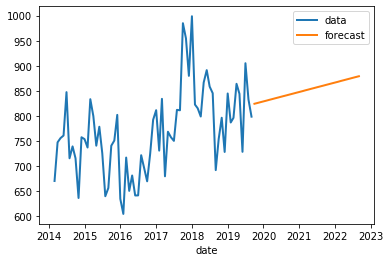

In [59]:
model_ar.fit(series)
pred = model_ar.predict(n = 36)

series.plot(label='data', lw=2)
pred.plot(label='forecast', lw=2)
plt.legend()

## Ensembling several predictions
Let's simulate forecasts done by an ensemble of models

First, backtest over time using the models you want to use in the ensemble method.
We backtest over a forecast horizon of 6 months from 2007.

In [60]:
split = int(np.round(series.pd_series().shape[0] * .8))
split_date = series.pd_series().index[split]

models = [Prophet()]#, Arima(), AutoArima(), ExponentialSmoothing()]

historical_ar_preds = [simulate_forecast_ar(series, m, split_date, fcast_horizon_n=6, verbose=True)
                       for m in models]

Combine the individual simulated predictions. A regressive model in contrary to an auto regressive model doesn't forecast based on the previous values of the series but based on a set of features data points.

In this example we will use the StandardRegressiveModel which is a Linear Regression, the features are the predictions made by backtesting and the Linear Regression model will be trained on 12 points (12 pairs of predictions).

On other hand, it will learn the optimal weights such as the weighted average of predictions is the closest to the groundtruth

In [65]:
def drop_end2(series: TimeSeries, ts: pd.Timestamp) -> 'TimeSeries':
        """
        Drops everything after ts, included
        """
        assert ts in series.pd_series().index, 'The provided timestamp is not in the time series'
        end_series: pd.Timestamp = ts# - self.freq()
#             return slice2(self.start_time(), end_series)
        return slice2(series, end_series)

In [66]:
def slice2(series: TimeSeries, end_ts: pd.Timestamp) -> 'TimeSeries':
        """
        Returns a new time series, starting later than [start_ts] (inclusive) and ending before [end_ts] (inclusive)
        :param start_ts:
        :param end_ts:
        :return:
        """
        start_ts = series.pd_series().index[0]
        assert end_ts >= start_ts, 'End timestamp must be strictly after start timestamp when slicing'
#         assert end_ts >= self.start_time(), 'End timestamp must be after the start of the time series when slicing'
#         assert start_ts <= self.end_time(), 'Start timestamp must be after the end of the time series when slicing'

        def _slice_not_none(s: Optional[pd.Series]) -> Optional[pd.Series]:
            if s is not None:
                s_a = s[s.index >= start_ts]
                return s_a[s_a.index <= end_ts]
            return None

#         return TimeSeries(_slice_not_none(self._series),
#                           _slice_not_none(self._confidence_lo),
#                           _slice_not_none(self._confidence_hi))
        return TimeSeries(_slice_not_none(series.pd_series()),
                          None,
                          None)

In [67]:
def _build_iterator(iterable, verbose):
    def _isnotebook():
        try:
            shell = get_ipython().__class__.__name__
            if shell == 'ZMQInteractiveShell':
                return True  # Jupyter notebook or qtconsole
            elif shell == 'TerminalInteractiveShell':
                return False  # Terminal running IPython
            else:
                return False  # Other type (?)
        except NameError:
            return False  # Probably standard Python interpreter

    if verbose:
        if _isnotebook():
            iterator = tqdm_notebook(iterable)
        else:
            iterator = tqdm(iterable)
    else:
        iterator = iterable
    return iterator

In [68]:
def simulate_forecast_regr2(feature_series: List[TimeSeries],
                           target_series: TimeSeries,
                           model: RegressiveModel,
                           start: pd.Timestamp,
                           fcast_horizon_n: int,
                           trim_to_series: bool = True,
                           verbose=False) -> TimeSeries:
    """
    Returns a TimeSeries containing the forecasts that would have been obtained from a given RegressiveModel,
    on a given forecast time horizon.
    TODO: optionally also return weights, when those are available in model
    TODO: (getattr(model.model, 'coef_', None) is not None)
    :param feature_series: the feature time series of the regressive model
    :param target_series: the target time series of the regressive model (i.e., the series to predict)
    :param model: the RegressiveModel to use
    :param start: when the forecasts start (i.e., the first time at which a prediction is produced for a future time)
    :param fcast_horizon_n: the forecast horizon
    :param trim_to_series: whether the returned predicted series has the end trimmed to match the end of the main series
    :param verbose: whether to print progress
    :return:
    """
    assert all([s.has_same_time_as(target_series) for s in feature_series]), 'All provided time series must ' \
                                                                             'have the same time index'
    assert start in target_series.pd_series().index, 'The provided start timestamp is not in the time series.'
    assert start != target_series.end_time(), 'The provided start timestamp is the last timestamp of the time series'

    last_pred_time = target_series.time_index()[-fcast_horizon_n - 2] if trim_to_series else target_series.time_index()[-2]

    # build the prediction times in advance (to be able to use tqdm)
    pred_times = [start]
    while pred_times[-1] <= last_pred_time:
        pred_times.append(pred_times[-1] + target_series.freq())
    
#     print('pred_times: {}'.format(pred_times))

    # what we'll return
    values = []
    times = []

    iterator = _build_iterator(pred_times, verbose)

    for pred_time in iterator:
        if not verbose:
            print('.', end='')
        # build train/val series
        train_features = [drop_end2(s, pred_time) for s in feature_series]
        train_target = target_series.drop_end(pred_time)
        val_features = [s.slice_n_points_after(pred_time + target_series.freq(), fcast_horizon_n)
                        for s in feature_series]

        model.fit(train_features, train_target)
        pred = model.predict(val_features)
        values.append(pred.values()[-1])  # store the N-th point
        times.append(pred.end_time())  # store the N-th timestamp

    return TimeSeries.from_times_and_values(pd.DatetimeIndex(times), np.array(values))

In [70]:
regrModel = StandardRegressiveModel(train_n_points=12)

series_val = series.intersect(historical_ar_preds[0])
print(type(series_val))
print(series_val.pd_series().shape)
print('type(historical_ar_preds): {}'.format(type(historical_ar_preds)))
print('type(historical_ar_preds)[0]: {}'.format(type(historical_ar_preds[0])))
print('historical_ar_preds[0].pd_series().shape: {}'.format(historical_ar_preds[0].pd_series().shape))
print('series_val.pd_series().index[0]:  {}'.format(series_val.pd_series().index[0]))
print('series_val.pd_series().index[-1]: {}'.format(series_val.pd_series().index[-1]))
print(type(series_val.pd_series().index[0]))

historical_pred = simulate_forecast_regr2(historical_ar_preds, series_val, regrModel,
                                         series_val.pd_series().index[0], fcast_horizon_n=5)

<class 'u8timeseries.timeseries.TimeSeries'>
(7,)
type(historical_ar_preds): <class 'list'>
type(historical_ar_preds)[0]: <class 'u8timeseries.timeseries.TimeSeries'>
historical_ar_preds[0].pd_series().shape: (7,)
series_val.pd_series().index[0]:  2019-02-01 00:00:00
series_val.pd_series().index[-1]: 2019-08-01 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
.

AssertionError: Could not infer frequency. Are some dates missing? Is Series too short (n=2)?

In [ ]:
# _freq = series.pd_series().index.inferred_freq
# print(_freq is None)
# print(_freq)

In [ ]:
# regrModel = StandardRegressiveModel(train_n_points=12)

# series_val = series.intersect(historical_ar_preds[0])
# print(type(series_val))
# print(series_val.pd_series().shape)
# # print('type(historical_ar_preds): {}'.format(type(historical_ar_preds)))
# # print('type(historical_ar_preds)[0]: {}'.format(type(historical_ar_preds[0])))
# # print('historical_ar_preds[0].pd_series().shape: {}'.format(historical_ar_preds[0].pd_series().shape))
# print('series_val.pd_series().index[0]:  {}'.format(series_val.pd_series().index[0]))
# print('series_val.pd_series().index[-1]: {}'.format(series_val.pd_series().index[-1]))

# split2 = int(np.round(series.pd_series().shape[0] * .8))
# split_date2 = series.pd_series().index[split2]
# print('type(split_date2): {}'.format(type(split_date2)))
# print('type(split_date2).date(): {}'.format(type(split_date2.date())))
# print('type(split_date2).timestamp(): {}'.format(type(split_date2.timestamp())))
# print(type(series_val))
# print('split_date2: {}'.format(split_date2 + 5))
# print((split_date2 + 5).date() in series_val.pd_series().index)

# historical_pred = simulate_forecast_regr2(historical_ar_preds, series_val, regrModel,
#                                          (split_date2 + 5).date(), fcast_horizon_n=6)

In [ ]:
# print(series_val.pd_series().index[0] + 1)
# print(series_val.pd_series().index[-1])
# print(split_date)

In [ ]:
# print(type(historical_ar_preds))
# print(type(historical_ar_preds[0]))
# print(historical_ar_preds[0].pd_series().index[0])
# print(historical_ar_preds[0].pd_series().index[-1])
# print(series_val.pd_series().index[0] + 1)
# print(split_date)

Compute errors and plot

In [ ]:
plt.figure(figsize=(8,5))

series.plot()
for i, m in enumerate(models):
    historical_ar_preds[i].plot(label=str(m))
    
    # intersect last part, to compare everything with ensemble
    ar_pred = historical_ar_preds[i].intersect(historical_pred)
       
    mape_er = mape(series.intersect(historical_pred), ar_pred)
    print('MAPE Error {}: {}'.format(m, mape_er))

print('MAPE Error ensemble: {}'.format(mape(series.intersect(historical_pred), historical_pred)))

historical_pred.plot(label='Ensemble')

plt.legend()